## **Extração de Características em Imagens**

In [15]:
## Importando as libs
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
from skimage.io import imread
import pandas as pd
import numpy as np
from skimage.feature import hog, local_binary_pattern

## Suprimindo Warnings
import warnings
warnings.filterwarnings('ignore')


IMAGES_DATABASE_BASE_PATH = "/Users/gilcesarf/git/repositories/imd/imd3002-202502/image-database"

# Função para calcular a moda
def mode_func(x):
    return x.mode().iloc[0] if not x.mode().empty else x.iloc[0]

# Função para converter a imagem para escala de cinza
def convert_to_grayscale(img):
    return rgb2gray(img)

# Função para extrair as features do LBP
def lbp_feature_extraction(lbp, n_points):
    # Criar histograma (descritor final)
    (hist, _) = np.histogram(
                    lbp.ravel(),
                    bins=np.arange(0, n_points + 3),
                    range=(0, n_points + 2))

    # Normalizar histograma
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)

    # Criar DataFrame diretamente com as features como colunas
    df2 = pd.DataFrame(hist.reshape(1, -1))
    df2.columns = df2.columns.map(lambda x: f'lbp_feature_{x+1}')

    return df2

# Função para processar LBP para uma resolução específica e armazenar resultado no dataframe
def process_lbp_for_resolution(df_imagens, idx, gray_image, resolution, radius, n_points):
    """
    Procesa LBP para uma resolução especifica e armazena resultado no dataframe
    
    Args:
        df_imagens: DataFrame principal
        idx: índice da imagen corrente
        gray_image: imagem em escala de cinza
        resolution: resolucao
        radius: raio para LBP
        n_points: número de pontos para LBP
    """
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    
    # Armazenando array numpy diretamente
    df_imagens.at[idx, f"lbp_{resolution}_{radius}_{n_points}"] = lbp
    df_imagens.at[idx, f"lbpfeat_{resolution}_{radius}_{n_points}"] = lbp_feature_extraction(lbp, n_points)
    print(
        f"\tLBP Raio {radius} Pontos {n_points:02d} - {resolution}x{resolution} -"+
        f"\tLBP shape: {df_imagens.at[idx, f'lbp_{resolution}_{radius}_{n_points}'].shape} -"+
        f"\tFeature shape: {df_imagens.at[idx, f'lbpfeat_{resolution}_{radius}_{n_points}'].shape}")

In [9]:
# Ler imagens do IMAGES_DATABASE_BASE_PATH e criar DataFrame
data_list = []
contador = 0
for filename in os.listdir(IMAGES_DATABASE_BASE_PATH):
    contador += 1
    print(f"Lendo arquivo {contador:03d}: {filename}")
    img = imread(os.path.join(IMAGES_DATABASE_BASE_PATH, filename))
    
    # Extrair raça do nome do arquivo (formato: raca_numero.jpg)
    # Remove a extensão .jpg e pega tudo antes do último underscore
    nome_sem_extensao = filename.split('.')[0]
    partes = nome_sem_extensao.split('_')
    raca = '_'.join(partes[:-1])  # Pega todas as partes exceto a última (número)
    
    # Extrair atributos básicos da imagem
    altura = img.shape[0]
    largura = img.shape[1]

    # Redimensionar imagens para 128x128 e 256x256
    img_128 = resize(img, (128, 128), anti_aliasing=True)
    img_256 = resize(img, (256, 256), anti_aliasing=True)

    # Converter imagens para escala de cinza
    gray_128 = convert_to_grayscale(img_128)
    gray_256 = convert_to_grayscale(img_256)
    
    # Adicionar dados ao dicionário
    data_list.append({
        'nome_arquivo': filename,
        'raca': raca,
        'altura': altura,
        'largura': largura,
        'img': img,
        'img_128': img_128,
        'img_256': img_256,
        'gray_128': gray_128,
        'gray_256': gray_256
    })

# Criar DataFrame
df_imagens = pd.DataFrame(data_list)



Lendo arquivo 001: basset_hound_112.jpg
Lendo arquivo 002: Birman_167.jpg
Lendo arquivo 003: saint_bernard_139.jpg
Lendo arquivo 004: Birman_173.jpg
Lendo arquivo 005: basset_hound_106.jpg
Lendo arquivo 006: saint_bernard_111.jpg
Lendo arquivo 007: saint_bernard_105.jpg
Lendo arquivo 008: saint_bernard_2.jpg
Lendo arquivo 009: Birman_2.jpg
Lendo arquivo 010: Birman_198.jpg
Lendo arquivo 011: Persian_221.jpg
Lendo arquivo 012: Persian_143.jpg
Lendo arquivo 013: Birman_49.jpg
Lendo arquivo 014: saint_bernard_41.jpg
Lendo arquivo 015: Persian_75.jpg
Lendo arquivo 016: saint_bernard_55.jpg
Lendo arquivo 017: Persian_61.jpg
Lendo arquivo 018: basset_hound_94.jpg
Lendo arquivo 019: Persian_49.jpg
Lendo arquivo 020: Birman_75.jpg
Lendo arquivo 021: Birman_61.jpg
Lendo arquivo 022: saint_bernard_69.jpg
Lendo arquivo 023: basset_hound_80.jpg
Lendo arquivo 024: Persian_180.jpg
Lendo arquivo 025: saint_bernard_82.jpg
Lendo arquivo 026: saint_bernard_96.jpg
Lendo arquivo 027: Persian_194.jpg
Lendo

In [10]:
# Exibir informações do DataFrame
print(f"\nDataFrame criado com {len(df_imagens)} imagens")
print("Primeiras 10 linhas:")
print(df_imagens[['nome_arquivo', 'raca', 'altura', 'largura']].head(10).to_string(index=True))
print(f"Colunas: {list(df_imagens.columns)}")

# Verificar raças únicas
print(f"\nRaças encontradas: {df_imagens['raca'].unique()}")
print(f"Número de raças: {df_imagens['raca'].nunique()}")

# Estatísticas de dimensões agrupadas por raça
print(f"\nEstatísticas das imagens por raça:")

stats = df_imagens.groupby('raca').agg({
    'altura': ['min', 'max', 'median', mode_func],
    'largura': ['min', 'max', 'median', mode_func]
}).round(0)

# Renomear apenas as colunas mode_func para moda
stats = stats.rename(columns={'mode_func': 'mode'})

print(stats)



DataFrame criado com 800 imagens
Primeiras 10 linhas:
            nome_arquivo           raca  altura  largura
0   basset_hound_112.jpg   basset_hound     500      374
1         Birman_167.jpg         Birman     375      500
2  saint_bernard_139.jpg  saint_bernard     500      333
3         Birman_173.jpg         Birman     333      500
4   basset_hound_106.jpg   basset_hound     357      500
5  saint_bernard_111.jpg  saint_bernard     426      500
6  saint_bernard_105.jpg  saint_bernard     375      500
7    saint_bernard_2.jpg  saint_bernard     375      500
8           Birman_2.jpg         Birman     334      500
9         Birman_198.jpg         Birman     400      600
Colunas: ['nome_arquivo', 'raca', 'altura', 'largura', 'img', 'img_128', 'img_256', 'gray_128', 'gray_256']

Raças encontradas: ['basset_hound' 'Birman' 'saint_bernard' 'Persian']
Número de raças: 4

Estatísticas das imagens por raça:
              altura                   largura                  
                 m

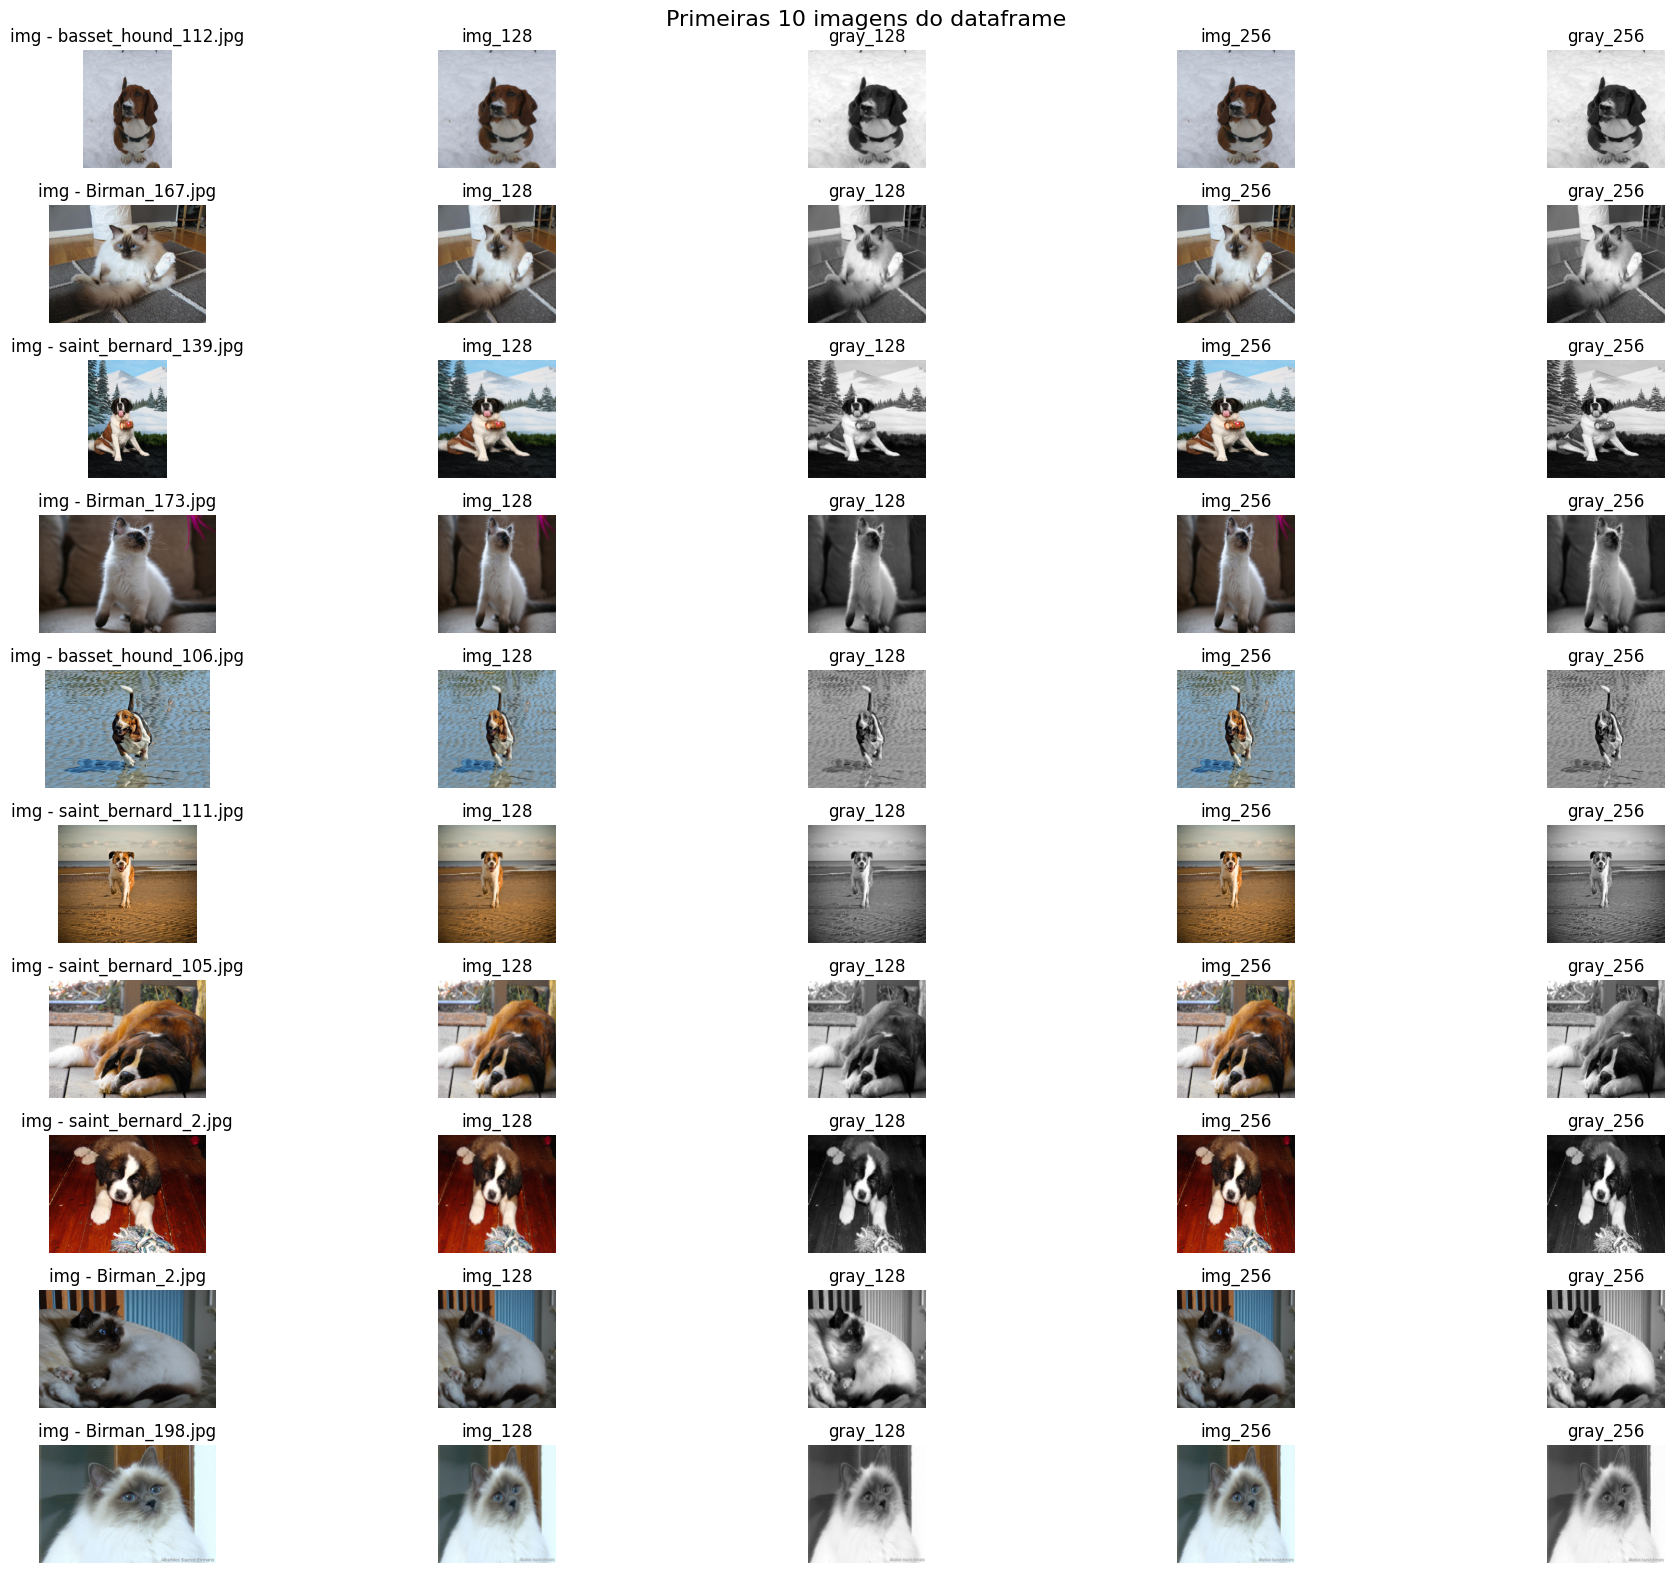

In [11]:

# Exibir as 5 primeiras imagens do dataframe
fig, axes = plt.subplots(10, 5, figsize=(20, 16))
fig.suptitle('Primeiras 10 imagens do dataframe', fontsize=16)

for i in range(10):
    # img
    axes[i, 0].imshow(df_imagens.iloc[i]['img'])
    axes[i, 0].set_title(f'img - {df_imagens.iloc[i]["nome_arquivo"]}')
    axes[i, 0].axis('off')
    
    # img_128
    axes[i, 1].imshow(df_imagens.iloc[i]['img_128'])
    axes[i, 1].set_title('img_128')
    axes[i, 1].axis('off')
    
    # gray_128
    axes[i, 2].imshow(df_imagens.iloc[i]['gray_128'], cmap='gray')
    axes[i, 2].set_title('gray_128')
    axes[i, 2].axis('off')
    
    # img_256
    axes[i, 3].imshow(df_imagens.iloc[i]['img_256'])
    axes[i, 3].set_title('img_256')
    axes[i, 3].axis('off')
    
    # gray_256
    axes[i, 4].imshow(df_imagens.iloc[i]['gray_256'], cmap='gray')
    axes[i, 4].set_title('gray_256')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

## Adicionar Local Binary Pattern (LBP)

In [16]:
# segundo o artigo referenciado pelo professor, o LBP não varia com a resolução. 
# Logo, vou trabalhar apenas com a resolução 256x256 e adicionar um 4 ponto (24, 64)
# configurações ( radius, n_points, resolution )
lbp_config = [ 
  (3, 8, 256), 
  (6, 16, 256), 
  (12, 32, 256),
  (24, 64, 256)
] # A ideia é manter uma resolução angular aproximadamente constante.

# Criando colunas LBP com tipo object para armazenar dataframes
for radius, n_points, resolution in lbp_config:
    df_imagens[f"lbp_{resolution}_{radius}_{n_points}"] = None
    df_imagens[f"lbpfeat_{resolution}_{radius}_{n_points}"] = None

# Processando cada imagem do dataframe com LBP
for idx, row in df_imagens.iterrows():
  print(f"Processando imagem {row['nome_arquivo']}")
  
  for radius, n_points, resolution in lbp_config:
      process_lbp_for_resolution(df_imagens, idx, row[f"gray_{resolution}"], resolution, radius, n_points)


Processando imagem basset_hound_112.jpg
	LBP Raio 3 Pontos 08 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 10)
	LBP Raio 6 Pontos 16 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 18)
	LBP Raio 12 Pontos 32 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 34)
	LBP Raio 24 Pontos 64 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 66)
Processando imagem Birman_167.jpg
	LBP Raio 3 Pontos 08 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 10)
	LBP Raio 6 Pontos 16 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 18)
	LBP Raio 12 Pontos 32 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 34)
	LBP Raio 24 Pontos 64 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 66)
Processando imagem saint_bernard_139.jpg
	LBP Raio 3 Pontos 08 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 10)
	LBP Raio 6 Pontos 16 - 256x256 -	LBP shape: (256, 256) -	Feature shape: (1, 18)
	LBP Raio 12 Pontos 32 - 256x256 -	LBP shape: (256, 256) -	Feature shap

In [17]:

print(f"\nDataFrame atualizado com {len(df_imagens)} imagens")
print(f"Novas colunas LBP: {[col for col in df_imagens.columns if 'lbp' in col]}")

df_imagens.iloc[0]



DataFrame atualizado com 800 imagens
Novas colunas LBP: ['lbp_256_3_8', 'lbpfeat_256_3_8', 'lbp_256_6_16', 'lbpfeat_256_6_16', 'lbp_256_12_32', 'lbpfeat_256_12_32', 'lbp_256_24_64', 'lbpfeat_256_24_64']


nome_arquivo                                      basset_hound_112.jpg
raca                                                      basset_hound
altura                                                             500
largura                                                            374
img                  [[[188, 190, 205], [190, 189, 205], [192, 191,...
img_128              [[[0.7299890596022588, 0.7558142085782149, 0.8...
img_256              [[[0.7231708039449565, 0.7510900393930383, 0.7...
gray_128             [[0.7536059843342547, 0.7640142818307382, 0.75...
gray_256             [[0.7485673217711686, 0.7532243254632729, 0.75...
lbp_256_3_8          [[2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
lbpfeat_256_3_8         lbp_feature_1  lbp_feature_2  lbp_feature_3...
lbp_256_6_16         [[17.0, 2.0, 2.0, 3.0, 17.0, 4.0, 7.0, 8.0, 7....
lbpfeat_256_6_16        lbp_feature_1  lbp_feature_2  lbp_feature_3...
lbp_256_12_32        [[33.0, 3.0, 1.0, 33.0, 3.0, 3.0, 4.0, 5.0, 33...
lbpfea

In [14]:
# HOG
from skimage.feature import hog

features_hog, hog_image = hog(gray, visualize=True)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG')
plt.axis('off')
plt.show()

NameError: name 'gray' is not defined

In [ ]:
# Extraindo as features do HOG - Imagens em Grayscale (no channel_axis=-1)
features_hog, hog_image = hog(gray, orientations=9, pixels_per_cell=(32, 32),
                    cells_per_block=(2, 2), visualize=True)

features_hog.shape

(1764,)

In [ ]:
# Printando o vetor de características
print(features_hog)

[0.30840168 0.27236038 0.15109431 ... 0.15252688 0.29306091 0.3529053 ]


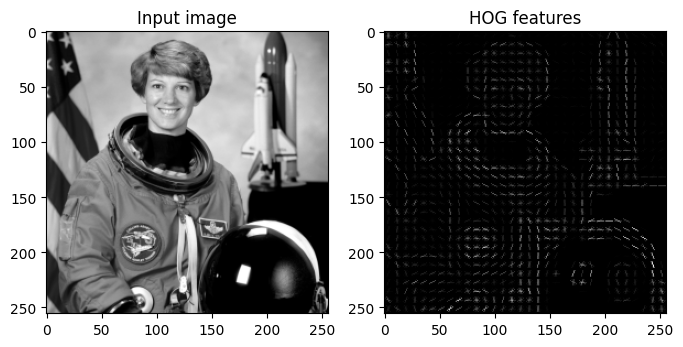

In [ ]:
from skimage import color
from skimage.feature import hog
from skimage import data, exposure, io
import matplotlib.pyplot as plt

# Loading an example image
image = data.astronaut()
image = resize(image, (256, 256), anti_aliasing=True)
image_gray = color.rgb2gray(image) # Converting image to grayscale

# Extract HOG features
features, hog_image = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Input image')

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG features')
plt.show()

In [ ]:
features.shape

(34596,)